In [1]:
import os
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
# Define image properties
Image_width = 128
Image_height = 128
Image_size = (Image_width, Image_height)
Image_channels = 3

In [3]:
# Prepare dataset for training
filenames = os.listdir('./data/train')

categories = []
for name in filenames:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [4]:
# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_width, Image_height, Image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [6]:
# Define callbacks and learning rate

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [7]:
# Manage Data
df['category'] = df['category'].replace({0:'cat', 1:'dog'})
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [26]:
# Train and validation data generation
train_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1.0/255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                   './data/train',
                                                   x_col='filename',
                                                   y_col = 'category',
                                                   target_size = Image_size,
                                                   calss_mode = 'categorical',
                                                   batch_size = batch_size)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                             './data/train',
                                                             x_col='filename',
                                                             y_col='category',
                                                             target_size=Image_size,
                                                             class_mode='categorical',
                                                             batch_size=batch_size)

test_datagen = ImageDataGenerator(rotation_range=15,
                                 rescale=1.0/255,
                                 shear_range=0.1,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
test_generator = train_datagen.flow_from_dataframe(train_df,
                                                  './data/train',
                                                  x_col='filename',
                                                  y_col='category',
                                                  batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [9]:
# Model training 
epochs = 10
history = model.fit(train_generator,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=total_validate//batch_size,
                             steps_per_epoch = total_train//batch_size,
                             callbacks = callbacks)


Epoch 1/10
1333/1333 [==============================] - 501s 375ms/step - loss: 0.9108 - accuracy: 0.6018 - val_loss: 0.6687 - val_accuracy: 0.6825
Epoch 2/10
1333/1333 [==============================] - 474s 356ms/step - loss: 0.5408 - accuracy: 0.7295 - val_loss: 0.6559 - val_accuracy: 0.7139
Epoch 3/10
1333/1333 [==============================] - 473s 355ms/step - loss: 0.4835 - accuracy: 0.7742 - val_loss: 0.7122 - val_accuracy: 0.6519
Epoch 4/10
1333/1333 [==============================] - 472s 354ms/step - loss: 0.4486 - accuracy: 0.7918 - val_loss: 0.4581 - val_accuracy: 0.7780
Epoch 5/10
1333/1333 [==============================] - 472s 354ms/step - loss: 0.4227 - accuracy: 0.8065 - val_loss: 0.4720 - val_accuracy: 0.8122
Epoch 6/10
1333/1333 [==============================] - 470s 353ms/step - loss: 0.4202 - accuracy: 0.8109 - val_loss: 0.4264 - val_accuracy: 0.8182
Epoch 7/10
1333/1333 [==============================] - 474s 355ms/step - loss: 0.3859 - accuracy: 0.8274 - val_

In [11]:
model.save('CatDogModel-1-10epochs.h5')

In [66]:
test_filenames = os.listdir('./data/test1')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [32]:
test_gen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_gen.flow_from_dataframe(test_df,
                                             './data/test1',
                                             x_col='filename',
                                             y_col=None,
                                             class_mode=None,
                                             target_size=Image_size,
                                             batch_size=batch_size,
                                             suffle=False)

Found 1499 validated image filenames.


In [33]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [34]:
predict

array([[0.99158   , 0.00842006],
       [0.35660666, 0.64339334],
       [0.83384115, 0.16615885],
       ...,
       [0.15472013, 0.8452799 ],
       [0.96954745, 0.03045252],
       [0.1643957 , 0.8356043 ]], dtype=float32)

In [36]:
test_df['category'] = np.argmax(predict, axis=1)

label_map = dict((v,k) for k, v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({'dog':1, 'cat':0})

In [37]:
test_df

,filename,category
0,136.jpg,0
1,489.jpg,1
2,1.jpg,0
3,10.jpg,0
4,100.jpg,0
...,...,...
1494,150.jpg,1
1495,151.jpg,0
1496,152.jpg,1
1497,153.jpg,0


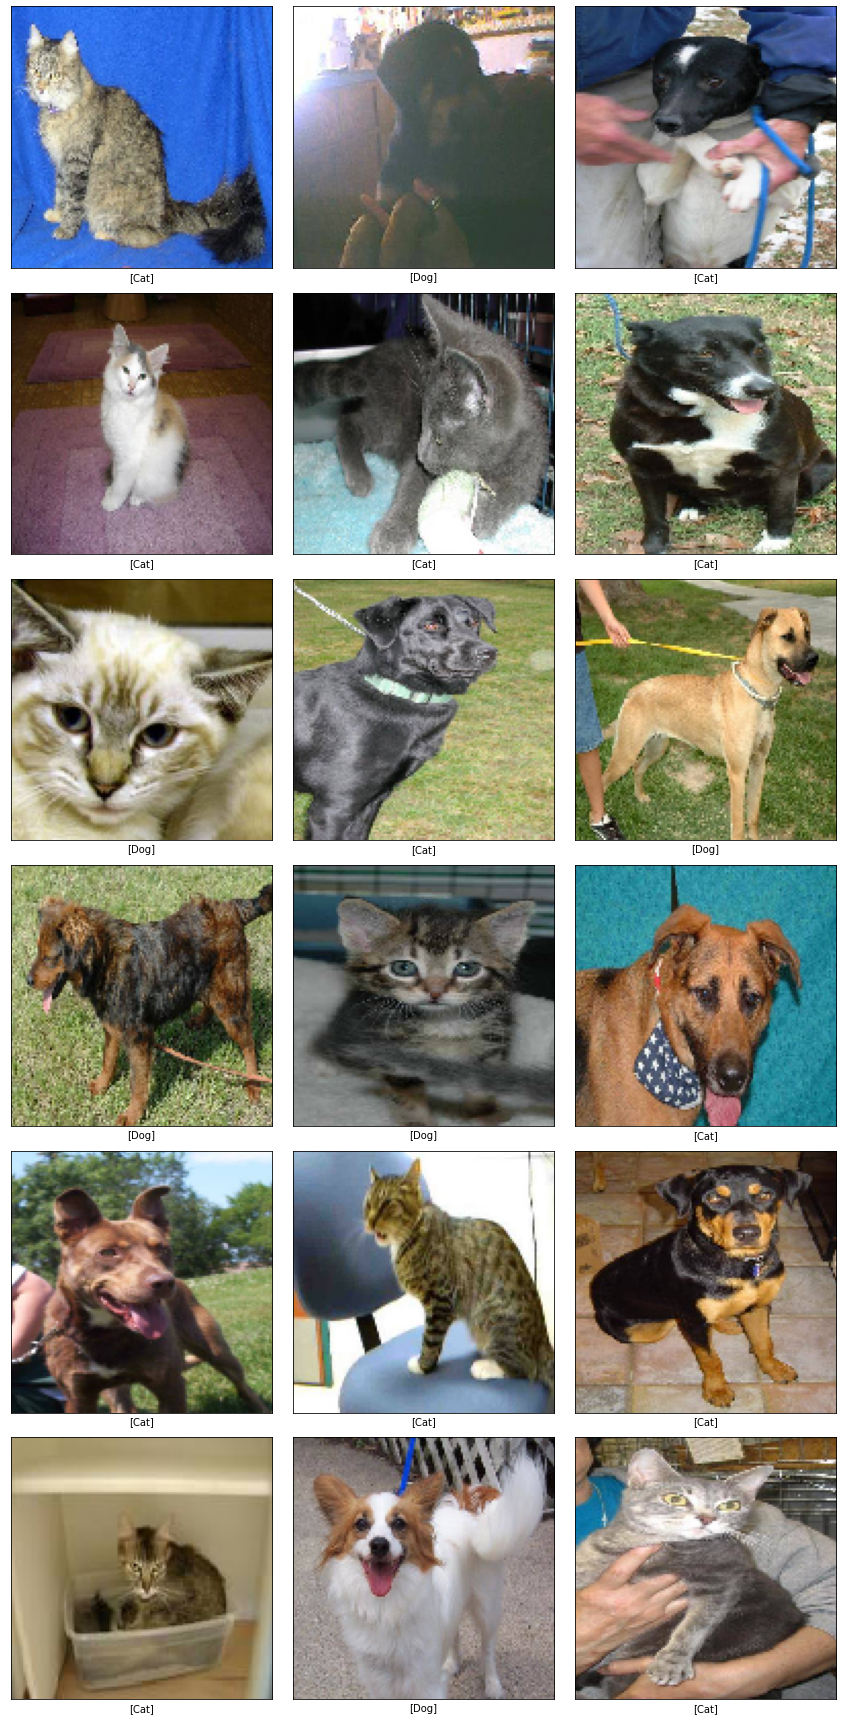

In [56]:
from matplotlib import pyplot as plt
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12,24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    #print(filename)
    category = row['category']
    image = load_img('./data/test1/'+filename, target_size=Image_size)
    plt.subplot(6,3, index+1)
    plt.imshow(image)
    plt.xlabel('[' + ('Dog' if category else 'Cat') + ']')
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

Dataset: https://www.kaggle.com/c/dogs-vs-cats/data